<h1 style="text-align: center; font-weight: bold;">Amirali Rahimi 810100146</h1>
<h1 style="text-align: center;">CA1 - Genetic</h1>

### Intro
In this project, we are going to solve curve fitting with *genetic algorithm*.

### Part 1) Define basic concepts   
First of all, we specify the chromosome we are using. Every chromosome is a list of integer and each integer shows the coefficent of the corresponding degree. For example, the chromosome $[1 , 5 , 2]$, shows us that the given polynomial is $ 1+5x+2x^2 $. And by the defenition of generation in `Genetic Algorithm`, Every generation, is made of some chromosomes. Therfore the implementation of `Chromosome` and `Generation` is like this:

In [31]:
import random
import copy
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from typing import List

Chromosome = List[int]
Generation = List[Chromosome]


 The curve fitting problem have 3 inputs which are:
- *`polynomial degree`*: Degree of the given polynomial equation
- *`coefficent ranges`*: The ranges that every coeffiecnt can be in
- *`points`*: Given points that we want to apply curve fitting on   
We store this inputs in a dataclass named `Input`. There are some datas that can be stored in a new datatype such as `Range` and `Point`.

In [32]:
class Range:
    start:int
    end:int
    def __init__(self, start, end):
        self.start = start
        self.end = end
    def __str__(self) -> str:
        return f"[{self.start} , {self.end}]"
    def __repr__(self) -> str:
        return str(self)
    
class Point:
    x:float
    y:float
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __str__(self) -> str:
        return f"Point({self.x} , {self.y})"
    def __repr__(self) -> str:
        return str(self)
    
@dataclass
class Input:
    polynomialDegree:int
    coEffRanges:List[Range]
    points:List[Point]

There is another dataclass called `HyperParams class` which contains different hyper parameters of the genetic algorithm. The considered hyper parameter for this GA is:
- *`crossOverProb`*: Probabilty of a cross over happening between 2 chromosomes
- *`crossOverFlipProb`*: Probabilty of switching to the other parent in the middle of a cross over
- *`mutationProb`*:Probabilty of a gene to be changed(not the probabilty of mutation happening to a chromsome)
- *`population`*: population of the generations
- *`moveToNextGen`*: Percentage of the whole chromosomes to be considered as top chromosomes and go to next generation directly
- *`maxGeneration`*: Total number of generations the algorithm will create to find the solution

In [33]:
@dataclass
class HyperParams:
    crossOverProb:float
    crossOverFlipProb:float
    mutationProb:float
    population:int
    moveToNextGen:float
    maxGeneartion:int

After implementing the dataclasses and new datatypes, we want to generate some points of the polynomial. Since this task is time consuming to do manually, we make a new function to do it for us.

In [34]:
def generatePoints(number:int, coEffs:List[int], givenRange)->List[Point]:
    points : List[Point] = []
    for i in range(0, number):
        point = Point(0,0)
        point.x = random.randint(givenRange.start, givenRange.end)
        point.y = 0
        for j in range(0,len(coEffs)):
            point.y += coEffs[j]*pow(point.x, j)
        points.append(point)
    return points

### Part 2) Generate Primary Generation    
We implement a new function named `generateFirstGeneration` which generates our first generation.

In [35]:
def generateFirstGeneration(population:int, coEffRanges:List[Range])->Generation:
    generation : Generation = []
    for i in range(0, population):
        chromosome : Chromosome = []
        for j in range(0, len(coEffRanges)):
            chromosome.append(random.randint(coEffRanges[j].start, coEffRanges[j].end))
        generation.append(chromosome)
    return generation

### Part 3) Defenition and Implementation of Fitness Function    
We define a `unFitness` that shows how much a choromosome is unfit, so the less a chromosome is unfit, the more its fit. Therefore `the unfitness value for the true answer is 0`. The unFitness value for each choromosome is calculated with this equation: $$ unFitness_{Chromosome} =  \frac{1}{N} \displaystyle\sum_{i} \Biggl[point_i.y - \displaystyle\sum_{j} \biggl( chromosome_j*\Bigl(point_i.x\Bigr)^j\biggr)\Biggr]^2$$

In [36]:
def findUnFitness(points:List[Point], chromosome:Chromosome)->int:
    error = 0
    for i in range(0,len(points)):
        calculatedY = 0
        for j in range(0, len(chromosome)):
            calculatedY += chromosome[j]*pow(points[i].x, j)
        error += pow(calculatedY - points[i].y, 2)
    variance = error / len(points)
    return variance
             

### Part 4)
After defening the chromosome and the fitness function for the problem, we need to define crossOver and mutation functions which are used in other functions that I will explain later. So the functions are:
- `crossOver`: This function takes two chromosomes as the parent chromosomes and generate two childeren (We have a auxiliary function named generateChild). The algorithm that we used here is that for generating each child, we start to inherit from the first parent and keeps copying every gene of that parent to the child. In each gene that we iterate through, we change the inheritence to the other parent by the chance of `crossOverFlipProb`. And finally the function, returns these two generated childerene.
- `mutationInPool`: This function, takes a pool of chromosome and iterate through every gene of each chromosome and change the gene with probabilty of `mutationProb`. Finally the function returns a pool that some of chromosomes are mutated in it.

In [37]:
def generateChild(chr1:Chromosome, chr2:Chromosome, crossOverFlipProb:float)->Chromosome:
    child : Chromosome = []
    choosingFrom = "chr1"
    for i in range(0, len(chr1)):
        randFloat = random.uniform(0, 1)
        if(choosingFrom=="chr1" and randFloat>crossOverFlipProb):
            child.append(chr1[i])
        elif(choosingFrom=="chr1" and randFloat<=crossOverFlipProb):
            child.append(chr2[i])
            choosingFrom = "chr2"
        elif(choosingFrom=="chr2" and randFloat>crossOverFlipProb):
            child.append(chr2[i])
        else:
            child.append(chr1[i])
            choosingFrom = "chr1"
    return child

In [38]:
def crossOver(chr1:Chromosome, chr2:Chromosome, crossOverProb:float, crossOverFlipProb:float)->(Chromosome,Chromosome):
    childOne : Chromosome = []
    childTwo : Chromosome = []
    randFloat = random.uniform(0, 1)
    if(randFloat > crossOverProb):
        return [chr1, chr2]
    childOne = generateChild(chr1, chr2, crossOverFlipProb)
    childTwo = generateChild(chr1, chr2, crossOverFlipProb)
    return childOne, childTwo
    

In [39]:
def mutationInPool(pool:List[Chromosome], mutationProb, coEffRanges:List[Range])->List[Chromosome]:
    newPool = copy.deepcopy(pool)
    for i in range(0, len(newPool)):
        for j in range(0, len(newPool[i])):
            randFloat = random.uniform(0, 1)
            if(randFloat<mutationProb):
                newPool[i][j] = random.randint(coEffRanges[j].start, coEffRanges[j].end)
    return newPool

Before using the crossOver on the generation, `we need to create a mating pool` as we learned in the genetic algorithm. For this purpose, we need to sort the generation at first and after that, return a pool based on the algorithm we are using to generate the pool. in this function named `createMatingPool`, we assumed that `the passed generation is sorted`.    
We create this pool by the `rank-based-selection`. It means that if the generation has $100$ chromosomes, and the unfitness value for the sorted generation looks like this: $x_1<x_2<x_3<...<x_{100}$ the chance of choosing them is like this: $x_1=100k,x_2=99k,x_3=98k,...,x_{100}=k$

In [40]:
def createMatingPool(sortedGeneration:Generation)->List[Chromosome]:
    weights = []
    for i in range(0, len(sortedGeneration)):
        weights.append(i+1)
    matingPoolSize = len(sortedGeneration)
    matingPool = random.choices(sortedGeneration, weights=weights, k=matingPoolSize)
    return matingPool

After defining the `crossOver` funtion and `createMatingPool`, we are ready to do the cross over operation in the created pool. So this function functionality is pretty simple, we get mating pool and call crossOver function for every pair in the pool.

In [41]:
def doCrossOverInPool(matingPool:List[Chromosome], crossOverProb:float, crossOverFlipProb:float)->List[Chromosome]:
    crossedPool : List[Chromosome] = []
    for i in range(0,len(matingPool),2):
        child1, child2 = crossOver(matingPool[i],matingPool[i+1],crossOverProb,crossOverFlipProb)
        crossedPool.append(child1)
        crossedPool.append(child2)
    return crossedPool

### Part 5) Apply Genetic Algorithm on Problem
Here we have all the needed functions and we just need to apply those just where we need to. So we define some stages that helps understanding what the process is like:
- `Create First Generation`: Here we create our first generation using our `generateFirstGeneration` function
- `Sort The Generation`: Since our `createMatingPool` functions need a sorted generation, we sort the generation by each chromosome unFitness value that is calculated with `findUnFitness` function
- `Check Return Condition`: We should stop the algorithm if we have reached the maximum generated generations or found the soultion. So after sorting the generation, we check the best chromsome of this generation's unFitness value and if it was equal to $0$, we return `(True, answer)`. Else, we check the generationNum and if it had reached the limit, we return the `(False, best chromsome of the generation)`.
- `Carry Top Chromosomes`: Before doing cross over and mutation operations, we carry some top chromosomes of the generation directly into next generation based on `moveToNextGen` hyper parameter.(They also `participate` in cross over and mutation)
- `Create Mating Pool`: Now we need to create a pool to apply the cross over on. The only thing to note is that the pool size is equal to generation size.
- `Do Cross Over in Pool`: Now the pool is ready to apply cross over on it's chromosomes. So we do so.
- `Do Mutation in Pool` : Here we have a pool which are crossed over. So we apply mutation function on the pool.
- `Next Generation is Ready`: After all, we have all the chromosomes we need to generate the next generation. We had $moveToNextGen*generationSize$ chromosomes from earlier, so we pick $(1-moveToNextGen)*generationSize$ from the `final pool` which causes the next generation size to be equal to previous generation.


In [42]:
def solve(inp:Input, hypParam:HyperParams)->(bool, Chromosome, List[Chromosome], List[int]):
    bestChrs : List[Chromosome] = []
    unFitnessChanges : List[int] = []
    nextGen = generateFirstGeneration(hypParam.population, inp.coEffRanges)
    generationNum = 1
    while(True):
        currGen = copy.deepcopy(nextGen)
        # print("CURRGEN",currGen)
        unFitness = [findUnFitness(inp.points, currGen[i]) for i in range(len(currGen))]
        sortedTuple = sorted(zip(currGen, unFitness), key=lambda pair:pair[1])
        sortedUnfitness = [pair[1] for pair in sortedTuple]
        sortedGen = [pair[0] for pair in sortedTuple]
        unFitnessChanges.append(sortedUnfitness[0])
        bestChrs.append(sortedGen[0])
        
        if(sortedUnfitness[0] == 0):
            return True, sortedGen[0], bestChrs, unFitnessChanges
        elif(generationNum>=hypParam.maxGeneartion):
            return False, sortedGen[0], bestChrs, unFitnessChanges
        
        moveToNextNum = int(hypParam.moveToNextGen*hypParam.population)
        straightToNext = copy.deepcopy(sortedGen[:moveToNextNum])
        # print("STRAIGHT",straightToNext)
        
        matingPool = createMatingPool(currGen)
        crossedPool = doCrossOverInPool(matingPool, hypParam.crossOverProb, hypParam.crossOverFlipProb)
        mutatedPool = mutationInPool(crossedPool, hypParam.mutationProb, inp.coEffRanges)
        # print("MUTATED",mutatedPool)
        nextGen = straightToNext + mutatedPool[:hypParam.population-moveToNextNum]
        generationNum += 1
        
    

In [43]:
def plot(solved, coEffs, unFitnessChanges):
    print(solved)
    x = np.linspace(-10, 10, 100)
    y1 = np.polyval(coEffs, x)
    y2 = np.polyval(solved, x)
    plt.plot(x, y1)
    plt.plot(x, y2, marker='o', linestyle='None', markersize=1, markeredgewidth=1, markerfacecolor='white', markeredgecolor='red')
    plt.title('found soultion and the primary input')
    plt.show()
    
    x = list(range(1, len(unFitnessChanges) + 1))
    plt.title('change of unFitness')
    plt.plot(x, unFitnessChanges)

    plt.show()
    
    

Here we just initialize Input and HyperParam and call solve function with these inputs.

True [12, 9, 2, -13] 0.0
[12, 9, 2, -13]


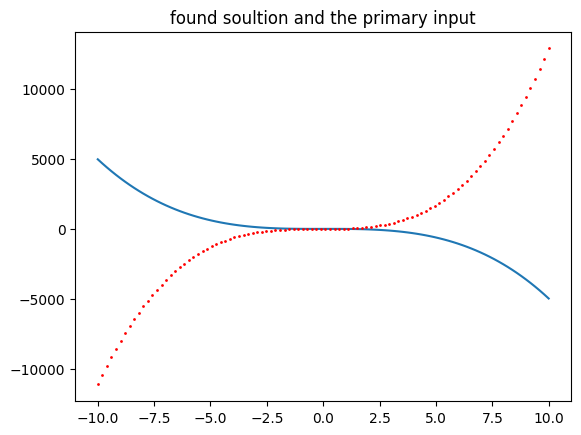

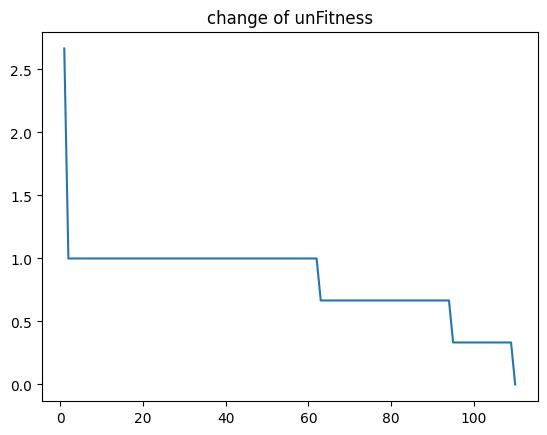

In [44]:
inp = Input(
    polynomialDegree = 3,
    coEffRanges = [Range(-10,10), Range(-10,10), Range(-10,10)],
    points = [Point(0,1), Point(-1,0), Point(1,5)]
)

hypParam = HyperParams(
    crossOverProb = 0.75,
    crossOverFlipProb = 0.2,
    mutationProb = 0.05,
    population = 400,
    moveToNextGen = 0.1,
    maxGeneartion = 2000
)

solved, result, bestChrOfGens, unFitnessChanges = solve(inp, hypParam)
print(solved, result, unFitnessChanges[-1])
plot(result, [0,-5,0,2,-1], unFitnessChanges)

In [45]:
thisRange = Range(-100, 100)
coEfficents = [0,-5,0,2,-1]
points : List[Point] = generatePoints(5, coEfficents, thisRange)
print(points)

[Point(-84 , -50972124), Point(-24 , -359304), Point(1 , -4), Point(-48 , -5529360), Point(17 , -73780)]


### Part 6) Analysing results

<font size="5"> Question 1)</font>What problems very small or very big populations causes?  
<font size="5" color="#FFFF99"> Answer)</font> If the population is too big, obviously the algorithm efficency gets ruined and it will take so much time to find the solution. On the other hand, if the population is too small, the variety of chromosomes decreases and it causes the algorithm finding the soultion in much more algorithm steps. `It probably converge faster to a local maximum but we hope we quit this local extermum with a good mutation in more steps`.
<hr>

<font size="5"> Question 2)</font>Effects of growing population in every geneartion on percision and speed?    
<font size="5" color="#FFFF99"> Answer)</font> The problem that we are facing here is that the more we go forward in the algorithm, we keep getting slower because of the population growth. So the speed will `decrease`. But the effect on the algorithm percision is discussable. It completely depends on how we create the added new chromosomes. If we add the cross over result and parents both, we will face the same problem as we add the mutation result with the chromosome itself, which is the added chromosomes aren't much different than the previous chromosomes. The bad thing happening here is that `we neither have the percision of the high amount of population nor the small population speed`.
<hr>

<font size="5"> Question 3)</font>Effects of cross over and mutation operation and compare them.   
<font size="5" color="#FFFF99"> Answer)</font> cross over is designed with the purpose of combining 2 good chromosomes and make the childeren that `covers each parent's flaws`. So hopefully we made a child or two that is a better chromosome than both of the parents. On the other hand mutation is there for `a chromosome that have pretty good genes and is ruined by a bad value of a single gene(or more)`, so after mutating that chromosome and hopefully changing that bad gene, we make a much better chromosome.  
Crossover is done with a much higher chance that mutation.  
We can't use only one of this operations because each of them is designed for a special purpose and none of them can fill each other's place.
Because if we only use cross over, `there is a high chance of getting stuck in a local maximum`, and if we only use mutation, `there is not a special improvement in every generation`, and for fixing this problem `if we increase the mutation chance`, we will face a new problem that this is not a genetic algorithm anymore and `we are literally generating new generations only by chance`. `In this situation algorithm will go through the whole state space`.
<hr>

<font size="5"> Question 4)</font>Approaches that make the algorithm find the answer faster  
<font size="5" color="#FFFF99"> Answer)</font>Changing the `hyper parameters` and assigning the right amount for every one of them,is the best way to make the algorithm run faster.
<hr>

<font size="5"> Question 5)</font>Solution to stagnated chromosomes and getting stuck  
<font size="5" color="#FFFF99"> Answer)</font> The cause of this effect, is `getting stuck` in a local maximum due to `similarity of chromosomes` to each other. Mutation is designed for this particular problem. We can higher the chance of mutation operation. Another solution is to `multi-start` the algorithm.(With new first generation)
<hr>

<font size="5"> Question 6)</font>Stopping the algorithm if the solution doesn't exist  
<font size="5" color="#FFFF99"> Answer)</font> We set a hyper parameter named `maxGenerations` that limits algorithm steps. This can work perfectly with above question approach which is `multi-starting`
<hr>

<font size="5"> Question 7)</font>How does increasing the polynomial degree affects the algorithm speed?  
<font size="5" color="#FFFF99"> Answer)</font> `Intuitively` we can say that if the polynomial degree increases, the algorithm take more time. But if we want to exactly figure out how much more the algorithm takes time, first we need to find the algorithm complexity. Since the algorithm worst case is `to generate all the possible state space`, the complexity of the algorithm is $O(state-space)$. The state space grows exponentially (the chromosome with $10$ genes that every gene has $20$ states, the state space is equal to $20^{10}$) so the `algorithm time, will increase exponentially`.

<font size="5"> Question 8)</font>How does increasing or decreasing the number of points affect algorithm time?  
<font size="5" color="#FFFF99"> Answer)</font> For `uniquely identifing a curve`, we need one more point than the polynomial degree which we call `uniqueNum`. If we were given less points than uniqueNum, there are $\infty$ curves that we can match with those points. So `the less points that we are given` (In case these points number are less than unique num), `the less time` it takes to find a curve to fit. But in case  `the points number are greater equal than uniqueNum`, `the more the points are, the more it helps to find the given curve` because our chromosomes unFitness will update better and leads us to answer pretty fast. so in this case, `the slowest answer is when the points number is equal to uniqueNum`, and we get faster solution by increasing the given points number.